# Microsoft ML MNIST Deep Learning Tutorial

1. [Overview](#Overview)
2. [Fitting Models That Identify Handprint Digits](#Digits)
3. [What's Next?](#Next)

## <a id="Overview">1. OVERVIEW</a>

Microsoft Machine Learning, or Microsoft ML for short, is an R package within Microsoft R Services that includes powerful machine learning algorithms and associated tools. The tutorial is an introduction to Microsoft ML for data scientists who want to take advantage of its unique capabilities.  It is intended primarily for those who are comfortable with using Microsoft R Services for data science, and want to see an end-to-end example that uses Microsoft ML to carry out common data science tasks.

## <a id="Digits">2. FITTING MODELS THAT IDENTIFY HANDPRINT DIGITS</a>

The tutorial steps through the fitting of a model for identifying handprinted digits from 0 through 9 in carefully prepared gray-scale images. Since there are ten digits to identify, this is called a multi-class classification problem.

The tutorial begins from data imported from a database of MNIST images. In this tutorial, the features are the pixel values of the images. Then, a model is fit by multiple learning algorithms, and the performance of these fit models is compared to select the best one. The initial and final steps in this process will be familiar to Microsoft R Services users, while the model fitting and performance evaluation steps will involve new Microsoft ML commands.

This tutorial is an example of deep learning because it shows the use of convolutional neural networks to automatically learn features from images, before using these features to classify the images.

### <a id="Packages">2.1. LOADING THE PACKAGES</a>

The tutorial is broken into steps, the first being loading the Microsoft ML package. When you execute the first step, there should be no output.

In [1]:
#-----------------------------------------------------------------------
# 1. Load packages.
#-----------------------------------------------------------------------
if (!suppressPackageStartupMessages(require("MicrosoftML",
                                            quietly = TRUE,
                                            warn.conflicts = FALSE))) {
    stop("The MicrosoftML package does not seem to be installed, so this\n",
         "script cannot be run. If Microsoft R Server with MML is installed,\n",
         "you may need to switch the R engine option. In R Tools for Visual\n",
         "Studio, this option is under:\n",
         "\tR Tools -> Options -> R Engine.\n",
         "If Microsoft R Server with MML is not installed, you can download it\n",
         "from https://microsoft.sharepoint.com/teams/TLC/SitePages/MicrosoftML.aspx\n")
}

### <a id="Import">2.2. IMPORT DATA</a>

The second step consists of importing the data we will use to fit a model. There is only one table of data: the MNIST table. This section imports that table into an Xdf. These Xdfs are an efficient way of working with large amounts of data. They are files in which the rows are grouped in blocks whose size is specified by the parameter rowsPerBlock (omitted here).

In [2]:
#-----------------------------------------------------------------------
# 2. Import data.
#-----------------------------------------------------------------------

# The directory containing data files.
dataDir <- file.path("Data")

# Verify that the data file exists.
if (!file.exists(file.path(dataDir, "MNIST.xdf"))) {
    stop("The data files needed for running this script cannot be found.\n",
         "You may need to set R's working directory to the location of the Data\n",
         "directory.\n")
}

The MNIST table has one row per image, and 786 columns: Label, V2 through V785, and splitVar. The Label identifies the digit present in the image, one of 0, 1, 2, 3, 4, 5, 6, 7, 8, or 9. The V2 through V785 are the pixels of the 28 by 28 pixel images. And the splitVar identifies which images have historically been used in training and which have been used in testing.

In [3]:
# The imported MNIST images.
dataset <- RxXdfData(file.path(dataDir, "MNIST.xdf"))

We can see from the output that the activity table has 70,000 rows. Counts showing the number of images for each digit can be obtained as follows:

In [4]:
t(as.data.frame(rxSummary(~ Label, dataset)$categorical))

Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.005 seconds
Rows Read: 10000, Total Rows Processed: 20000, Total Chunk Time: 0.001 seconds
Rows Read: 10000, Total Rows Processed: 30000, Total Chunk Time: Less than .001 seconds
Rows Read: 10000, Total Rows Processed: 40000, Total Chunk Time: Less than .001 seconds
Rows Read: 10000, Total Rows Processed: 50000, Total Chunk Time: Less than .001 seconds
Rows Read: 10000, Total Rows Processed: 60000, Total Chunk Time: Less than .001 seconds
Rows Read: 10000, Total Rows Processed: 70000, Total Chunk Time: 0.001 seconds 
Computation time: 0.022 seconds.


Label,0,1,2,3,4,5,6,7,8,9
Counts,6903,7877,6990,7141,6824,6313,6876,7293,6825,6958


### <a id="Split">2.3. SPLIT THE DATASET INTO TRAIN AND TEST</a>

To create train and test sets, data are usually randomly split by tweet into two datasets. For this tutorial, we will use the split historically used for these data by Yann LeCun, as is given by the column splitVar.

In [5]:
#-----------------------------------------------------------------------
# 3. Split the dataset into train and test data.
#-----------------------------------------------------------------------
# Split the data between train and test sets reproducing LeCun's split.
dataSplit <-
    rxSplit(dataset,
            splitByFactor = "splitVar",
            outFilesBase = tempfile())

# Name the train and test datasets.
dataTrain <- dataSplit[[1]]
dataTest <- dataSplit[[2]]

Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.218 seconds 
Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 1.292 secondsRows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.223 seconds 
Rows Read: 10000, Total Rows Processed: 20000, Total Chunk Time: 0.983 secondsRows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.246 seconds 
Rows Read: 10000, Total Rows Processed: 30000, Total Chunk Time: 0.997 secondsRows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.245 seconds 
Rows Read: 10000, Total Rows Processed: 40000, Total Chunk Time: 1.143 secondsRows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.255 seconds 
Rows Read: 10000, Total Rows Processed: 50000, Total Chunk Time: 1.142 secondsRows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.275 seconds 
Rows Read: 10000, Total Rows Processed: 60000, Total Chunk Time: 1.284 secondsRows Read: 10000, Total Rows Processed: 10000, Total

We can see from the above output that there are 60,000 images in the training set, and 10,000 images in the test set. Below, we see the count of each digit in the training and test data.

In [6]:
t(as.data.frame(rxSummary(~ Label, dataTrain)$categorical))
t(as.data.frame(rxSummary(~ Label, dataTest)$categorical))

Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.005 seconds
Rows Read: 10000, Total Rows Processed: 20000, Total Chunk Time: Less than .001 seconds
Rows Read: 10000, Total Rows Processed: 30000, Total Chunk Time: Less than .001 seconds
Rows Read: 10000, Total Rows Processed: 40000, Total Chunk Time: Less than .001 seconds
Rows Read: 10000, Total Rows Processed: 50000, Total Chunk Time: Less than .001 seconds
Rows Read: 10000, Total Rows Processed: 60000, Total Chunk Time: 0.001 seconds 
Computation time: 0.015 seconds.


Label,0,1,2,3,4,5,6,7,8,9
Counts,5923,6742,5958,6131,5842,5421,5918,6265,5851,5949


Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.008 seconds 
Computation time: 0.020 seconds.


Label,0,1,2,3,4,5,6,7,8,9
Counts,980,1135,1032,1010,982,892,958,1028,974,1009


### <a id="Model">2.4. DEFINE THE MODEL</a>

The model is a formula that describes what column has the label, and what columns are to be used to rxPredict the label. Since we will use the pixel values of the images as features, we create a formula that says that Label is to be rxPredicted by these features.

In [7]:
#-----------------------------------------------------------------------
# 4. Define the model to be fit.
#-----------------------------------------------------------------------
# The variables in the data
allVars <- names(dataTrain)

# The image's pixel values.
xVars <- setdiff(allVars, c("Label", "splitVar"))

# The model is a formula that says that an image is to be classified
# using its pixel values.
model <- formula(paste("Label ~", paste(xVars, collapse = " + ")))

The left-hand side of the formula is the label, while the right-hand side lists the rxPredictors.

*Note: We do not print this formula because of its size.*

### <a id="Fit">2.5. FIT THE MODEL</a>

The model will be fit by learners that can rxPredict class data: rxLogisticRegression, rxNeuralNet with a simple deep learning architecture, and rxNeuralNet with LeCun's Net5 architecture. In the next section, each fit will be used to score the test data. The comments in this section give a glimpse of the kind of work done by each learner.

We begin by fitting a multi-class logistic regression. This approach is not deep learning, and  provides a benchmark for comparison of the performance and learning times of the deep learning approaches.

In [8]:
#-----------------------------------------------------------------------
# 5. Fit the model using different learners.
#-----------------------------------------------------------------------
# Fit the model with rxLogisticRegression. This finds the variable weights that
# are most useful for classifying images. The rxLogisticRegression learner
# automatically adjusts the weights to select those variables that are
# most useful for classification. Unlike the convolutional network
# approaches shown below, this logistic regression does not take into
# account the spatial relationships between the pixels of the images.
rxLogisticRegressionFit <- rxLogisticRegression(model, dataTrain, type = "multiClass")

Automatically adding a MinMax normalization transform, use 'norm=Warn' or 'norm=No' to turn this behavior off.
Beginning read for block: 1
Rows Read: 10000, Read Time: 0.145, Transform Time: 0
Beginning read for block: 2
Rows Read: 10000, Read Time: 0.105, Transform Time: 0
Beginning read for block: 3
Rows Read: 10000, Read Time: 0.096, Transform Time: 0
Beginning read for block: 4
Rows Read: 10000, Read Time: 0.091, Transform Time: 0
Beginning read for block: 5
Rows Read: 10000, Read Time: 0.096, Transform Time: 0
Beginning read for block: 6
Rows Read: 10000, Read Time: 0.093, Transform Time: 0
Beginning read for block: 7
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 10000, Read Time: 0.128, Transform Time: 0
Beginning read for block: 2
Rows Read: 10000, Read Time: 0.135, Transform Time: 0
Beginning read for block: 3
Rows Read: 10000, Read Time: 0.131, Transform Time: 0
Beginning read for block: 4
Rows Read: 10000, Read Time: 0.105, Transform Ti

We then fit a four-layer convolutional neural network (CNN). This network learns spatial features in two successive sets of convolutional feature map. It then combines the results of the second convolutional layer into 100 features, and these are used by the result layer to classify the images.

In [9]:
#-----------------------------------------------------------------------
# Fit the model with rxNeuralNet. This learns which neural network
# weights are needed to classify images as digits based on the pixel
# value variables. The 'numIterations' input says how many times the
# learners goes over the training data to find the correct weights.
#-----------------------------------------------------------------------
# TRY THIS: Double numIterations from 9 to 18 and see:
# 1. how much better the fit network gets at digit classification, and
# 2. how much longer the learner needs to fit the network.
#-----------------------------------------------------------------------
# The definition of the convolutional neural network.
rxNeuralNet <- readChar(file.path(dataDir, "MNIST.nn"),
                      file.info(file.path(dataDir, "MNIST.nn"))$size)
rxNeuralNetFit <- rxNeuralNet(model, data = dataTrain,
                          type = "multiClass",
                          numIterations = 9,
                          netDefinition = rxNeuralNet,
                          initWtsDiameter = 1.0,
                          normalize = "No")

Not adding a normalizer.
Beginning read for block: 1
Rows Read: 10000, Read Time: 0.128, Transform Time: 0
Beginning read for block: 2
Rows Read: 10000, Read Time: 0.11, Transform Time: 0
Beginning read for block: 3
Rows Read: 10000, Read Time: 0.111, Transform Time: 0
Beginning read for block: 4
Rows Read: 10000, Read Time: 0.107, Transform Time: 0
Beginning read for block: 1
Rows Read: 10000, Read Time: 0.14, Transform Time: 0
Beginning read for block: 2
Rows Read: 10000, Read Time: 0.106, Transform Time: 0
Beginning read for block: 3
Rows Read: 10000, Read Time: 0.1, Transform Time: 0
Beginning read for block: 4
Rows Read: 10000, Read Time: 0.104, Transform Time: 0
Beginning read for block: 5
Rows Read: 10000, Read Time: 0.154, Transform Time: 0
Beginning read for block: 6
Rows Read: 10000, Read Time: 0.133, Transform Time: 0
Beginning read for block: 7
No rows remaining. Finished reading data set. 
Wrote 60000 rows across 2 columns in 00:00:02.7223789
Using: SSE Math
Loading net fr

Compare the neural network and the logistic regression:How long did each take to fit?

Finally, we fit a seven-layer CNN similar to the one described by Yann LeCun in his 1998 paper. In successive layers, this network alternates sets of convolutional feature maps and subsampling.  It then combines the 120 features produced by the last convolutional layer into 84 features, and these are used by the result layer to classify the images. For more information, see http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf.

*Note: The cell below can take more than eight minutes to run to completion.*

In [10]:
#-----------------------------------------------------------------------
# Fit the model with rxNeuralNet. This network is an approximation of
# LeNet-5, Yann LeCun's 1998 convolutional network.
#-----------------------------------------------------------------------
# TRY THIS: Increase numIterations until the fit of LeCun-5 reaches 99%
# accuracy.
#-----------------------------------------------------------------------
# The definition of the LeCun-5 neural network.
leCun5Net <- readChar(file.path(dataDir, "LeCun5.nn"),
                      file.info(file.path(dataDir, "LeCun5.nn"))$size)
if (file.exists(file = file.path(dataDir, "leCun5NetFit.RData"))) {
    load(file = file.path(dataDir, "leCun5NetFit.RData"))
} else {
    leCun5NetFit <- rxNeuralNet(model, data = dataTrain,
                              type = "multiClass",
                              numIterations = 9,
                              netDefinition = leCun5Net,
                              initWtsDiameter = 1.0,
                              normalize = "No")
    save(leCun5NetFit, file = file.path(dataDir, "leCun5NetFit.RData"))
}

Compare LeCun's neural network and the previous one: How long did each take to fit?

In the next two sections, we will compute the classification performance of each method.

### <a id="Score">2.6. SCORE THE TEST DATA</a>

Each fit will be used to score the test data, and then the score columns are concatenated in one table. This provides each fit's rxPredictions for side-by-side convenient comparison.

In [11]:
#-----------------------------------------------------------------------
# 6. Score the held-aside test data with the fit models.
#-----------------------------------------------------------------------
# The scores are each record's probability of being one of the ten
# digits. The rxPredicted label correspond to the digit with the highest
# score. We combine each learner's rxPredictions and the label into one
# Xdf.
rxLogisticRegressionScores <-
    rxPredict(rxLogisticRegressionFit, dataTest, suffix = ".rxLogisticRegression",
            extraVarsToWrite = "Label",
            outData = tempfile(fileext = ".xdf"))
rxNeuralNetScores <-
    rxPredict(rxNeuralNetFit, dataTest, suffix = ".rxNeuralNet",
            outData = tempfile(fileext = ".xdf"))
leCun5NetScores <-
    rxPredict(leCun5NetFit, dataTest, suffix = ".leCun5Net",
            outData = tempfile(fileext = ".xdf"))
fitScores <- rxMerge(list(rxLogisticRegressionScores, rxNeuralNetScores, leCun5NetScores),
                     type = "oneToOne")
names(fitScores) <- gsub("PredictedLabel.", "", names(fitScores))

Beginning read for block: 1
Rows Read: 10000, Read Time: 0.138, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Elapsed time: 00:00:00.7597420
Finished writing 10000 rows.
Writing completed.
Beginning read for block: 1
Rows Read: 10000, Read Time: 0.13, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Elapsed time: 00:00:00.9389510
Finished writing 10000 rows.
Writing completed.
Beginning read for block: 1
Rows Read: 10000, Read Time: 0.124, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Elapsed time: 00:00:02.9220124
Finished writing 10000 rows.
Writing completed.
File merge progress at row: 10000
Time to merge data file: 0.109 seconds
Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.040 seconds 
File merge progress at row: 10000
Time to merge data file: 0.156 seconds


We see in the above results that the number of rows in the results is the same as the number of rows in the test data.

### <a id="Compare">2.7. COMPARE THE FIT MODEL PERFORMANCE</a>

For each fit model, its rxPredictions and the Label are used to compute a confusion table for that fit. A confusion table shows the numbers of each actual digit that was classified as one of the digits 0 through 9.

In [12]:
#-----------------------------------------------------------------------
# 7. Compare the performance of fit models.
#-----------------------------------------------------------------------
# Create square confusion tables. The entries of these tables count the
# number of images of a digit that were classified as being one of the
# ten digits. The entries on a table's main diagonal, stretching from
# the top-left corner to the bottom-right corner, count the number of
# images that were correctly classified. The row sums are the counts
# of the number of times each digit was in an image. The column sums
# are the counts of the number of times each digit was rxPredicted.
rxLogisticRegressionConfusion <-
    rxCrossTabs(~ Label:rxLogisticRegression, fitScores, returnXtabs = TRUE)
rxNeuralNetConfusion <-
    rxCrossTabs(~ Label:rxNeuralNet, fitScores, returnXtabs = TRUE)
leCun5NetConfusion <-
    rxCrossTabs(~ Label:leCun5Net, fitScores, returnXtabs = TRUE)

Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: Less than .001 seconds 
Computation time: 0.004 seconds.
Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.001 seconds 
Computation time: 0.004 seconds.
Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.001 seconds 
Computation time: 0.004 seconds.


Here is the confusion table for the rxLogisticRegression learner:

In [13]:
rxLogisticRegressionConfusion

     rxLogisticRegression
Label    0    1    2    3    4    5    6    7    8    9
    0  958    0    2    3    0    7    4    5    1    0
    1    0 1112    3    2    0    2    3    2   11    0
    2    6    8  931   14   10    3   13   10   34    3
    3    4    1   16  922    0   25    3   11   22    6
    4    1    1    5    3  920    0    9    3    8   32
    5   10    2    3   35    9  777   14    8   31    3
    6    9    3    5    2    8   15  912    2    2    0
    7    1    9   23    5    6    1    0  950    1   32
    8    7   10    5   21    9   26   10    8  867   11
    9   11    8    1    9   26    6    0   19    7  922

Each row of the table counts the images that show the row's digit, and each column has the images that were classified as the column's digit. The numbers on the diagonal show the counts of times the model fit with rxLogisticRegression correctly assigned a digit to an image. The off-diagonal numbers show the errors.

The single fitScores table also allows comparison of the rxPredictions of each learner:

In [14]:
rxCrossTabs(~ rxLogisticRegression:rxNeuralNet, fitScores, returnXtabs = TRUE)

Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.001 seconds 
Computation time: 0.003 seconds.


                    rxNeuralNet
rxLogisticRegression    0    1    2    3    4    5    6    7    8    9
                   0  969    0    6    5    0   12    9    0    3    3
                   1    0 1117   11    0    1    2    1   10   11    1
                   2    2    1  938   14    3    3   11   15    6    1
                   3    3    0   14  947    2   27    3    6   12    2
                   4    0    3    5    1  918   10    8    8    3   32
                   5    8    1    3   35    1  780   11    2   18    3
                   6    3    1   11    2    5   18  921    0    7    0
                   7    4    4    8   10    2    6    2  963    6   13
                   8    1    6   31   23    7   30    1    2  880    3
                   9    2    1    5    4   35    7    0   33    7  915

The numbers on the diagonal show that the model fit with rxLogisticRegression and with convolutional rxNeuralNet agree on most of their rxPredictions. The off-diagonal numbers show the areas of disagreement.

Below, the confusion tables are then used to compute the per-digit accuracy, precision, and recall for each fit.

In [15]:
# The accuracy of the fit models. This is the ratio of the number of
# correct classification of images as having a digit to the total
# number of images that were classified.
accuracy <-
    cbind(rxLogisticRegression = sum(diag(rxLogisticRegressionConfusion)) /
                             sum(rxLogisticRegressionConfusion),
          rxNeuralNet = sum(diag(rxNeuralNetConfusion)) /
                             sum(rxNeuralNetConfusion),
          leCun5Net = sum(diag(leCun5NetConfusion)) /
                             sum(leCun5NetConfusion))
rownames(accuracy) <- "Accuracy"
names(dimnames(accuracy)) <- c("", "Learner")

# The precision and recall of the fit model, by digit. For a given
# digit, the precision is the fraction of assignments of that digit to
# images that were correct. In contrast, the recall is the fraction of
# images of that digit that were correct assigned that digit.
precision <-
    rbind(rxLogisticRegression = diag(rxLogisticRegressionConfusion) /
                             colSums(rxLogisticRegressionConfusion),
          rxNeuralNet = diag(rxNeuralNetConfusion) /
                             colSums(rxNeuralNetConfusion),
          leCun5Net = diag(leCun5NetConfusion) /
                             colSums(leCun5NetConfusion))
names(dimnames(precision)) <- c("Learner", "Digit")

recall <-
    rbind(rxLogisticRegression = diag(rxLogisticRegressionConfusion) /
                             rowSums(rxLogisticRegressionConfusion),
          rxNeuralNet = diag(rxNeuralNetConfusion) /
                             rowSums(rxNeuralNetConfusion),
          leCun5Net = diag(leCun5NetConfusion) /
                            rowSums(leCun5NetConfusion))
names(dimnames(recall)) <- c("Learner", "Digit")

These accuracy, precision, and recall data are printed.

In [16]:
#-----------------------------------------------------------------------
# Report the results.
#-----------------------------------------------------------------------
# Print the fit models's accuracies, and their per digit precision and
# recall.
print(accuracy, digits = 2)
cat("\nPer digit precision:\n")
print(precision, digits = 2)
cat("\nPer digit recall:\n")
print(recall, digits = 2)

          Learner
           rxLogisticRegression rxNeuralNet leCun5Net
  Accuracy                 0.93        0.96      0.98

Per digit precision:
                      Digit
Learner                   0    1    2    3    4    5    6    7    8    9
  rxLogisticRegression 0.95 0.96 0.94 0.91 0.93 0.90 0.94 0.93 0.88 0.91
  rxNeuralNet          0.97 0.98 0.95 0.93 0.97 0.94 0.96 0.95 0.95 0.96
  leCun5Net            0.98 0.99 0.97 0.96 0.98 0.99 0.98 0.97 0.97 0.98

Per digit recall:
                      Digit
Learner                   0    1    2    3    4    5    6    7    8    9
  rxLogisticRegression 0.98 0.98 0.90 0.91 0.94 0.87 0.95 0.92 0.89 0.91
  rxNeuralNet          0.98 0.98 0.95 0.96 0.97 0.95 0.97 0.96 0.93 0.93
  leCun5Net            0.99 0.99 0.98 0.98 0.98 0.97 0.98 0.97 0.96 0.96


Finally, barplots are created to show side-by-side the per-digit precision and recall.

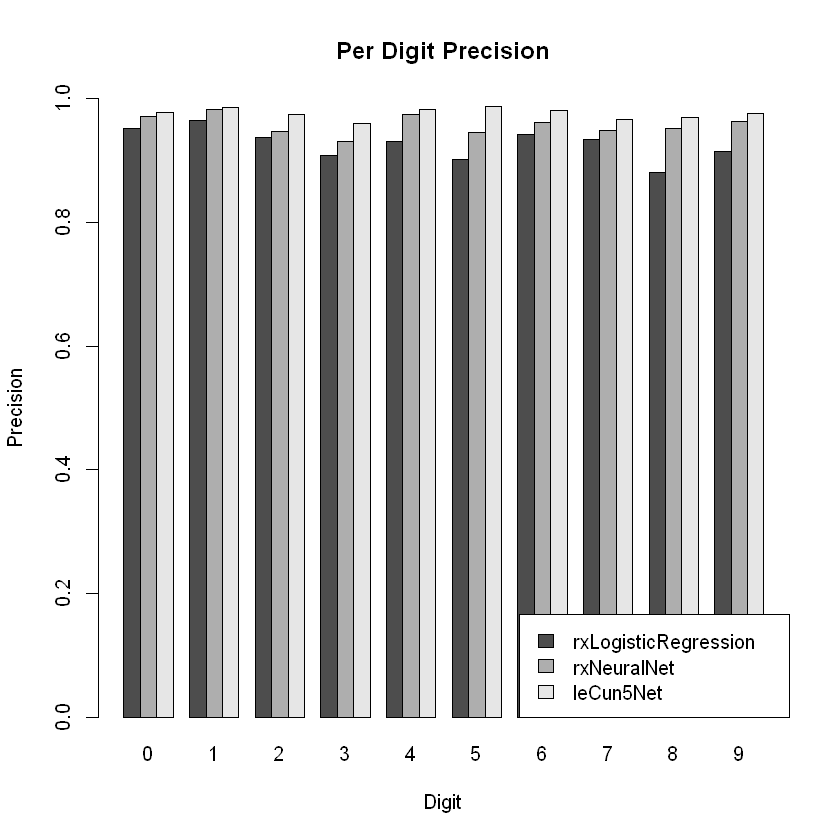

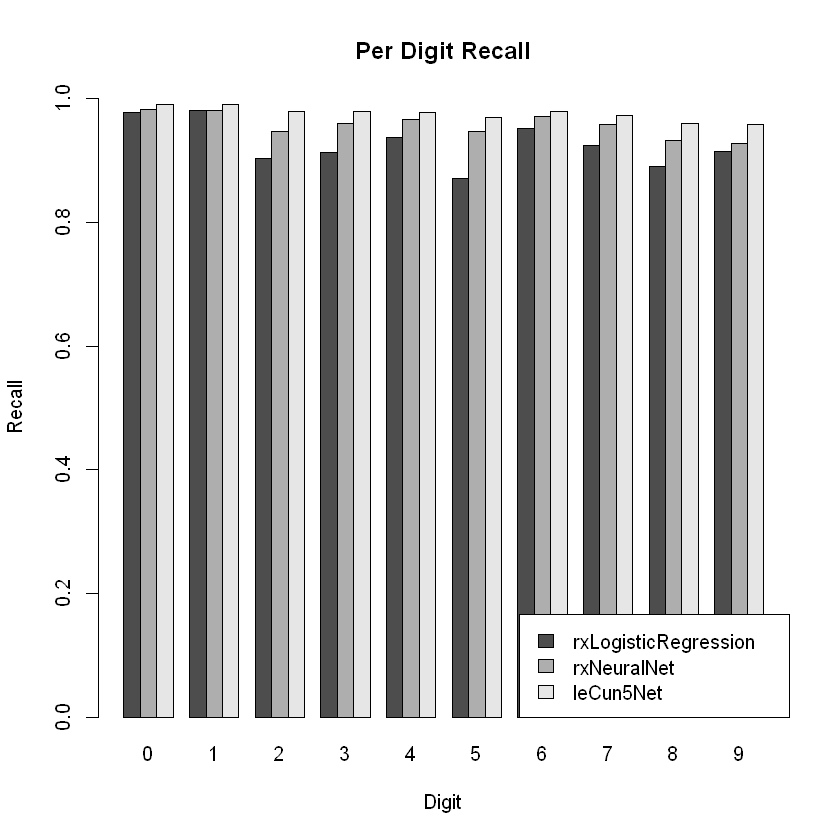

In [17]:
# Barplots showing side-by-side the per digit precision and recall
# achieved by the fit models on the test data.
barplot(precision,
        legend.text = TRUE, beside = TRUE,
        main = "Per Digit Precision",
        xlab = "Digit", ylab = "Precision", ylim = 0:1,
        args.legend = list(x = "bottomright"))
barplot(recall,
        legend.text = TRUE, beside = TRUE,
        main = "Per Digit Recall",
        xlab = "Digit", ylab = "Recall", ylim = 0:1,
        args.legend = list(x = "bottomright"))

## <a id="Next">3. WHAT'S NEXT?</a>

In the Microsoft ML samples directory, the script MNIST.R contains all the R code used in this tutorial. It also contains other scripts formatted to follow the steps used for this tutorial. Try them out interactively, and learn about other Microsoft ML capabilities.